In [4]:
from math import sqrt
import numpy as np
import matplotlib.path as mpl_path
import matplotlib.pyplot as plt
import pre_processing as pp
import csv
import pandas as pd
import tensorflow as tf
from point_grid import *

([0.8888864253556743,
  0.44069980963656014,
  -0.4391622162567516,
  -0.8857993410988176,
  -0.44029130479356093,
  0.43566662715689575],
 [0.0022623522528935343,
  0.7595224071186956,
  0.7621408747571852,
  -0.003681841859107009,
  -0.7608236190873481,
  -0.7594201731823192])

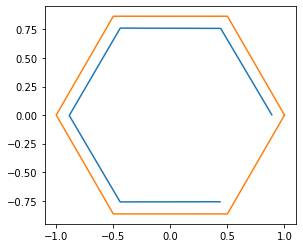

In [28]:
# Sanity testing polygon dataset. The means of all the columns should form a regular polygon. it does :)
df = pd.read_csv('data/6-gon-correct-procrustes.csv')

df = df[df.internal_nodes == 2.0].dropna(axis=1, how='all')
df = df[df.target_edge_length == 0.4]
df = df.drop(['target_edge_length', 'internal_nodes'], axis=1)
means = df.mean()
x = [means[0], means[2], means[4], means[6], means[8], means[10]]
y = [means[1], means[3], means[5], means[7], means[9], means[11]]

plt.plot(x, y)
plt.gca().set_aspect('equal')
pp.plot_polygon(pp.create_regular_ngon(6))
x, y


# Prediction pipeline for case: 6-gon with two internal nodes


meshed contour has 2.0 internal nodes!


array([[ 0.76882925,  0.0088887 ],
       [ 0.57299189,  0.98764589],
       [-0.44217163,  0.85596207],
       [-0.64542201, -0.23640291],
       [-0.82891347, -0.8303745 ],
       [ 0.57468596, -0.78571925]])

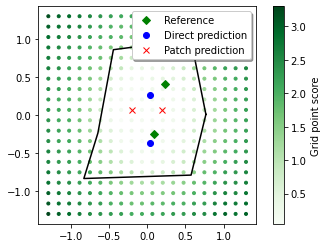

In [19]:

def predict_internal_node_count() -> int:
    return 2


# Pre-processing method for nn2. 
def prediction_pipeline_nn2(contour, internal_node_count):

    # Predict internal node count using neural network 1.
    internal_node_count = predict_internal_node_count()

    # Build point grid
    point_grid = generate_point_grid()
    patches = generate_patches(point_grid)

    # Pre-process contour with procrustes superimposition
    transformed_contour = pp.procrustes(contour)['transformed_contour'] 
    transformed_contour_data = [coordinate for point in transformed_contour for coordinate in point]

    # Load model from file
    model = tf.keras.models.load_model('model/correct-dropout-last')
    # model.summary()

    # Get patch data
    for patch in patches:
        patch_data = [coordinate for point in patch for coordinate in point.get_coordinates()]

        # Define prediction data
        features = np.append(transformed_contour_data, patch_data)
        prediction_data = np.expand_dims(features, axis=0)

        # Predict
        prediction_result = model(prediction_data).numpy()

        # Write predicted score to the point grid
        for i, p in enumerate(patch):
            p.score = prediction_result[0][i] 

    return point_grid


def direct_prediction_pipeline(contour_input_2):
    # Pre-process contour with procrustes superimposition
    transformed_contour_data = [coordinate for point in contour_input_2 for coordinate in point]

    # Load model
    direct_model = tf.keras.models.load_model("model/direct-internal-nodes")

    # Define prediction data
    features = transformed_contour_data
    direct_prediction_data = np.expand_dims(features, axis=0)

    # Predict
    direct_prediction_result = direct_model(direct_prediction_data).numpy()

    return direct_prediction_result


# Naive way of only checking the results on contours that the reference mesher would insert two points into
meshed_internal_node_count = -1
internal_node_count = predict_internal_node_count()

while meshed_internal_node_count != 2:
    contour = pp.create_random_ngon(6)
    transformed_contour = pp.procrustes(contour)['transformed_contour']

    meshed_contour = pp.mesh_contour(transformed_contour, 0.4)
    meshed_internal_points = meshed_contour[-4:]
    meshed_internal_node_count = int(meshed_contour[13])
    print(f"meshed contour has {meshed_contour[13]} internal nodes!")
    
predicted_point_grid = prediction_pipeline_nn2(transformed_contour, internal_node_count)
pg_internal_nodes = generate_internal_nodes_from_grid_score(predicted_point_grid, internal_node_count)


# Direct prediction without point grid
predicted_internal_nodes = direct_prediction_pipeline(contour)[0]


"""
|-------------------------
|       PLOTTING
|-------------------------
"""
flat_pgp = [point for row in predicted_point_grid for point in row]

pgp_x = [p.x for p in flat_pgp]
pgp_y = [p.y for p in flat_pgp]
pgp_s = [p.score for p in flat_pgp]

# Plot predicted points (green)
# plt.grid(b=True)
pl0 = plt.plot([meshed_internal_points[0], meshed_internal_points[2]], 
         [meshed_internal_points[1], meshed_internal_points[3]], 'gD',
            label="Reference",
            )
pl2 = plt.plot([predicted_internal_nodes[0], predicted_internal_nodes[2]], 
               [predicted_internal_nodes[1], predicted_internal_nodes[3]], 
               'bo',
               label="Direct prediction"
)
pl1 = plt.plot([x[0] for x in pg_internal_nodes], [y[1] for y in pg_internal_nodes], 'rx', label="Patch prediction")
# Plot transformed contour
pl3 = pp.plot_polygon(transformed_contour, style='k')

# Plot point grid
pl4 = plt.scatter(pgp_x, pgp_y, c=pgp_s, cmap=plt.cm.Greens, marker='.')
plt.colorbar(label="Grid point score")
plt.legend(loc='upper right', shadow='true')
plt.gca().set_aspect('equal')
transformed_contour

In [ ]:
# Try to scatter plot grid points to see whats going on
flat_pgp = [point for row in predicted_point_grid for point in row]

pgp_x = [p.x for p in flat_pgp]
pgp_y = [p.y for p in flat_pgp]
pgp_s = [p.score for p in flat_pgp]

# Plot predicted points (green)
plt.grid(b=True)
plt.plot([x[0] for x in internal_nodes], [y[1] for y in internal_nodes], 'rx')
plt.plot(meshed_internal_points[0], meshed_internal_points[1], 'gD')
plt.plot(meshed_internal_points[2], meshed_internal_points[3], 'gD')

# Plot transformed contour
pp.plot_polygon(transformed_contour, style='r')

# Plot point grid
plt.scatter(pgp_x, pgp_y, c=pgp_s, cmap=plt.cm.Greens, marker='.')
plt.colorbar()

plt.gca().set_aspect('equal')



In [ ]:
# Test data
point_grid_test = generate_point_grid()
test_points = [(-0.234, -0.234), (0.234, 0.234)]
transformed_contour = pp.procrustes(pp.create_random_ngon(6))['transformed_contour']
calculate_score(point_grid_test, test_points, transformed_contour)

internal_nodes = generate_internal_nodes_from_grid_score(point_grid_test, len(test_points))

# Try to scatter plot grid points to see whats going on
flat_pgp = [point for row in point_grid_test for point in row]

pgp_x = [p.x for p in flat_pgp]
pgp_y = [p.y for p in flat_pgp]
pgp_s = [p.score for p in flat_pgp]

# Plot predicted points (green)
plt.grid(b=True)
plt.plot([x[0] for x in test_points], [y[1] for y in test_points], 'gD')
plt.plot([x[0] for x in internal_nodes], [y[1] for y in internal_nodes], 'rx')

# Plot transformed contour
pp.plot_polygon(transformed_contour, style='r')

# Plot point grid
plt.scatter(pgp_x, pgp_y, c=pgp_s, cmap=plt.cm.Greens, marker='.')
plt.colorbar()

plt.gca().set_aspect('equal')



# Creating dataset for patches

In [20]:
# 1. Read meshed contours to dataframe
df = pd.read_csv('data/6-gon-correct-procrustes.csv')

# Csv-file to write to.
new_csv_path = "data/patch-data-correct-procrustes.csv"

# 2. Separate based on internal nodes added. We choose 2 as it has the highest incidence.
#    -> Remove empty columns with dropna.
#    -> Remove target_edge_length column (experiment)
df = df[df.internal_nodes == 2.0].dropna(axis=1, how='all')
dataset = df[df.target_edge_length == 0.4]
dataset = dataset.drop(['target_edge_length', 'internal_nodes'], axis=1)

write_patch_collection_to_csv(generate_patch_collection(dataset), new_csv_path)


# Neural network 2: predicting internal node positions (or rather: predict grid score)

For now we only train the network on the dataset with:
- 6 edges
- 2 internal nodes
- 100 2x2 patches


450 - 1s - loss: 0.2476 - val_loss: 0.1670
Epoch 4685/5000
450/450 - 1s - loss: 0.2472 - val_loss: 0.1662
Epoch 4686/5000
450/450 - 1s - loss: 0.2495 - val_loss: 0.1702
Epoch 4687/5000
450/450 - 1s - loss: 0.2477 - val_loss: 0.1709
Epoch 4688/5000
450/450 - 1s - loss: 0.2484 - val_loss: 0.1689
Epoch 4689/5000
450/450 - 1s - loss: 0.2474 - val_loss: 0.1677
Epoch 4690/5000
450/450 - 1s - loss: 0.2472 - val_loss: 0.1674
Epoch 4691/5000
450/450 - 1s - loss: 0.2489 - val_loss: 0.1659
Epoch 4692/5000
450/450 - 1s - loss: 0.2475 - val_loss: 0.1669
Epoch 4693/5000
450/450 - 1s - loss: 0.2487 - val_loss: 0.1674
Epoch 4694/5000
450/450 - 1s - loss: 0.2478 - val_loss: 0.1663
Epoch 4695/5000
450/450 - 1s - loss: 0.2474 - val_loss: 0.1684
Epoch 4696/5000
450/450 - 1s - loss: 0.2475 - val_loss: 0.1653
Epoch 4697/5000
450/450 - 1s - loss: 0.2485 - val_loss: 0.1660
Epoch 4698/5000
450/450 - 1s - loss: 0.2472 - val_loss: 0.1673
Epoch 4699/5000
450/450 - 1s - loss: 0.2480 - val_loss: 0.1669
Epoch 4700/5

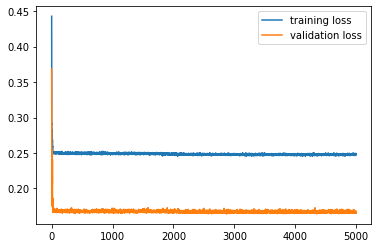

In [31]:
# packages
from tensorflow.keras import layers, metrics
import tensorflow_addons as tfa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn.utils
import datetime
import os

#  %load_ext tensorboard

# Parameters
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-2
EPOCHS = 5000
BATCH_SIZE = 512

model_path = 'model/correct-dropout-last'
patches = pd.read_csv('data/patch-data-correct-procrustes.csv')
# patches = pd.read_csv('data/patches-dataset-test.csv')

# Split dataset into 70/15/15 training/validation/test
patches_train = patches.sample(frac=0.85, random_state=0)
patches_test = patches.drop(patches_train.index)

# Shuffle dataset
patches_train = sklearn.utils.shuffle(patches_train)
patches_test = sklearn.utils.shuffle(patches_test)

# Split dataset into features and labels; last 4 columns 
# (predicted grid scores of a patch) are the labels.
train_features = patches_train.iloc[:, :-4]
train_labels = patches_train.iloc[:, -4:]

test_features = patches_train.iloc[:, :-4]
test_labels = patches_train.iloc[:, -4:]

model = tf.keras.Sequential([
    tf.keras.Input(shape=(20,)),
    layers.BatchNormalization(),

    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dropout(0.25),

    layers.Dense(4),
])

model.summary()

decay_steps= 10_000
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(1e-1, decay_steps, 1e-3)


model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(
                  learning_rate=lr_schedule,
              ),
              )

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=EPOCHS//5, min_delta=0.0001)
callbacks_list = [checkpoint]
history = model.fit(train_features,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_split=0.18,
                    verbose=2,
                    callbacks=callbacks_list,
                    )

# Evaluate the model
train_acc = model.evaluate(
    train_features, train_labels, verbose=0)
test_acc = model.evaluate(
    test_features, test_labels, verbose=0)
print('Training data loss: %.3f, Test data loss: %.3f' %
        (train_acc, test_acc))

# plot history
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()





(0.15, 0.3)

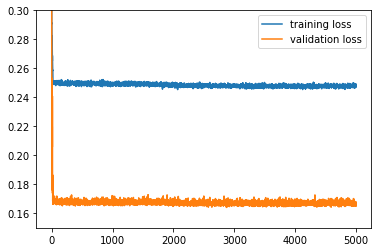

In [37]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.ylim(0.15, 0.3)

# Stat gathering for nn2

1. Create random contour.
2. Find internal mesh points with gmsh, grid nn and direct nn.
3. Calculate how often grid/direct is outside, and the mean euclidean error.

In [32]:
grid_model_path = 'model/correct-dropout-last'
direct_model_path = 'model/direct-internal-nodes'


# Pre-processing method for nn2. 
def prediction_pipeline_nn2(contour, internal_node_count):

    # Predict internal node count using neural network 1.
    internal_node_count = predict_internal_node_count()

    # Build point grid
    point_grid = generate_point_grid()
    patches = generate_patches(point_grid)

    # Pre-process contour with procrustes superimposition
    transformed_contour = pp.procrustes(contour)['transformed_contour'] 
    transformed_contour_data = [coordinate for point in transformed_contour for coordinate in point]

    # Load model from file
    model = tf.keras.models.load_model(grid_model_path)
    # model.summary()

    # Get patch data
    for patch in patches:
        patch_data = [coordinate for point in patch for coordinate in point.get_coordinates()]

        # Define prediction data
        features = np.append(transformed_contour_data, patch_data)
        prediction_data = np.expand_dims(features, axis=0)

        # Predict
        prediction_result = model(prediction_data).numpy()

        # Write predicted score to the point grid
        for i, p in enumerate(patch):
            p.score = prediction_result[0][i] 

    return point_grid


def direct_prediction_pipeline(contour_input_2):
    # Pre-process contour with procrustes superimposition
    transformed_contour_data = [coordinate for point in contour_input_2 for coordinate in point]

    # Load model
    direct_model = tf.keras.models.load_model(direct_model_path)

    # Define prediction data
    features = transformed_contour_data
    direct_prediction_data = np.expand_dims(features, axis=0)

    # Predict
    direct_prediction_result = direct_model(direct_prediction_data).numpy()

    return direct_prediction_result


def calc_dist_error(contour, predicted: list, reference: list) -> list:
    # Returns the dist error of each given point.
    pct_error = []
    # Define contour (for finding points inside)
    contour_path = mpl_path.Path(contour)

    for p_point in predicted:
        error = 100
        if contour_path.contains_point(p_point):
            for r_point in reference:
                distance = sqrt((p_point[0]-r_point[0])
                                        ** 2 + (p_point[1] - r_point[1])**2)
                if distance < error:
                    error = distance
        else:
            error = -1
        pct_error.append(error)
 
    return pct_error


sample_size = 40
dist_error_direct = []
dist_error_grid = []

from IPython.display import clear_output
for i in range(sample_size):
    clear_output(wait=True)
    print("\r", f"processing contour {i+1} of {sample_size}", end="")
    # Naive way of only checking the results on contours that the reference mesher would insert two points into
    meshed_internal_node_count = -1
    internal_node_count = 2

    while meshed_internal_node_count != 2:
        contour = pp.create_random_ngon(6)
        transformed_contour = pp.procrustes(contour)['transformed_contour']

        meshed_contour = pp.mesh_contour(transformed_contour, 0.4)
        meshed_internal_points = meshed_contour[-4:]
        meshed_internal_node_count = int(meshed_contour[13])
        
        
    predicted_point_grid = prediction_pipeline_nn2(transformed_contour, internal_node_count)
    grid_prediction = generate_internal_nodes_from_grid_score(predicted_point_grid, internal_node_count)

    # Direct prediction without point grid
    direct_prediction_raw = direct_prediction_pipeline(contour)[0]
    direct_prediction = list(zip(direct_prediction_raw[::2], direct_prediction_raw[1::2]))
    
    reference_nodes = list(zip(meshed_internal_points[::2], meshed_internal_points[1::2]))

    dist_error_direct.append(calc_dist_error(transformed_contour, direct_prediction, reference_nodes))
    dist_error_grid.append(calc_dist_error(transformed_contour, grid_prediction, reference_nodes))



 processing contour 40 of 40

In [33]:
# dist_error_direct, dist_error_grid
def find_mean_and_worst_error(error_list):
    total_e_mean = 0
    total_e_worst = 0
    outside = 0   
    for mesh in error_list:
        # -1 means predicted point was outside contour
        if mesh[0] == -1 or mesh[1] == -1:
            if sum(mesh) == -2:
                outside += 2 
            else:
                outside += 1 
            continue

        total_e_worst += max(mesh)
        total_e_mean += sum(mesh)/2

    e_mean = total_e_mean/len(error_list)
    e_worst = total_e_worst/len(error_list)
    
    return [round(e_mean, 3), round(e_worst, 3), outside/len(error_list)]

# direct_prediction_stats = find_mean_and_worst_error(dist_error_direct)
grid_prediction_stats = find_mean_and_worst_error(dist_error_grid)
grid_prediction_stats


[0.2, 0.266, 0.0]